<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Python for Algorithmic Trading

**Chapter 04 &mdash; Vectorized Backtesting**

## Making Use of Vectorization

### Vectorization with NumPy 

In [ ]:
v = [1, 2, 3, 4, 5]

In [2]:
sm = [2 * i for i in v]

In [3]:
sm

[2, 4, 6, 8, 10]

In [4]:
2 * v

[1, 2, 3, 4, 5, 1, 2, 3, 4, 5]

In [5]:
import numpy as np

In [6]:
a = np.array(v)

In [7]:
a

array([1, 2, 3, 4, 5])

In [8]:
type(a)

numpy.ndarray

In [9]:
2 * a

array([ 2,  4,  6,  8, 10])

In [10]:
0.5 * a + 2

array([2.5, 3. , 3.5, 4. , 4.5])

In [11]:
a = np.arange(12).reshape((4, 3))

In [12]:
a

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11]])

In [13]:
2 * a

array([[ 0,  2,  4],
       [ 6,  8, 10],
       [12, 14, 16],
       [18, 20, 22]])

In [14]:
a ** 2

array([[  0,   1,   4],
       [  9,  16,  25],
       [ 36,  49,  64],
       [ 81, 100, 121]])

In [15]:
a.mean()

5.5

In [16]:
np.mean(a)

5.5

In [17]:
a.mean(axis=0)

array([4.5, 5.5, 6.5])

In [18]:
np.mean(a, axis=1)

array([ 1.,  4.,  7., 10.])

### Vectorization with pandas

In [19]:
a = np.arange(15).reshape(5, 3)

In [20]:
a

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14]])

In [21]:
import pandas as pd

In [22]:
columns = list('abc')

In [23]:
columns

['a', 'b', 'c']

In [24]:
index = pd.date_range('2021-7-1', periods=5, freq='B')

In [25]:
index

DatetimeIndex(['2021-07-01', '2021-07-02', '2021-07-05', '2021-07-06',
               '2021-07-07'],
              dtype='datetime64[ns]', freq='B')

In [26]:
df = pd.DataFrame(a, columns=columns, index=index)

In [27]:
df

,a,b,c
2021-07-01,0,1,2
2021-07-02,3,4,5
2021-07-05,6,7,8
2021-07-06,9,10,11
2021-07-07,12,13,14


In [28]:
2 * df

,a,b,c
2021-07-01,0,2,4
2021-07-02,6,8,10
2021-07-05,12,14,16
2021-07-06,18,20,22
2021-07-07,24,26,28


In [29]:
df.sum()

a    30
b    35
c    40
dtype: int64

In [30]:
np.mean(df)

a    6.0
b    7.0
c    8.0
dtype: float64

In [31]:
df['a'] + df['c']

2021-07-01     2
2021-07-02     8
2021-07-05    14
2021-07-06    20
2021-07-07    26
Freq: B, dtype: int64

In [32]:
0.5 * df.a + 2 * df.b - df.c

2021-07-01     0.0
2021-07-02     4.5
2021-07-05     9.0
2021-07-06    13.5
2021-07-07    18.0
Freq: B, dtype: float64

In [33]:
df['a'] > 5

2021-07-01    False
2021-07-02    False
2021-07-05     True
2021-07-06     True
2021-07-07     True
Freq: B, Name: a, dtype: bool

In [34]:
df[df['a'] > 5]

,a,b,c
2021-07-05,6,7,8
2021-07-06,9,10,11
2021-07-07,12,13,14


In [35]:
df['c'] > df['b']

2021-07-01    True
2021-07-02    True
2021-07-05    True
2021-07-06    True
2021-07-07    True
Freq: B, dtype: bool

In [36]:
0.15 * df.a + df.b > df.c

2021-07-01    False
2021-07-02    False
2021-07-05    False
2021-07-06     True
2021-07-07     True
Freq: B, dtype: bool

## Strategies based on Simple Moving Averages

### Getting into the Basics 

In [79]:
import pandas as pd
import numpy as np
import scipy
import matplotlib

In [80]:
raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv',
                   index_col=0, parse_dates=True).dropna()

In [81]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2516 non-null   float64
 1   MSFT.O  2516 non-null   float64
 2   INTC.O  2516 non-null   float64
 3   AMZN.O  2516 non-null   float64
 4   GS.N    2516 non-null   float64
 5   SPY     2516 non-null   float64
 6   .SPX    2516 non-null   float64
 7   .VIX    2516 non-null   float64
 8   EUR=    2516 non-null   float64
 9   XAU=    2516 non-null   float64
 10  GDX     2516 non-null   float64
 11  GLD     2516 non-null   float64
dtypes: float64(12)
memory usage: 255.5 KB


In [82]:
data = pd.DataFrame(raw['EUR='])

In [83]:
data.rename(columns={'EUR=': 'price'}, inplace=True)

In [84]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   2516 non-null   float64
dtypes: float64(1)
memory usage: 39.3 KB


In [85]:
data['SMA1'] = data['price'].rolling(42).mean()

In [86]:
data['SMA2'] = data['price'].rolling(252).mean()

In [87]:
data.tail()

,price,SMA1,SMA2
Date,,,
2019-12-24,1.1087,1.107698,1.119630
2019-12-26,1.1096,1.107740,1.119529
2019-12-27,1.1175,1.107924,1.119428
2019-12-30,1.1197,1.108131,1.119333
2019-12-31,1.1210,1.108279,1.119231


In [88]:
%matplotlib inline
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'

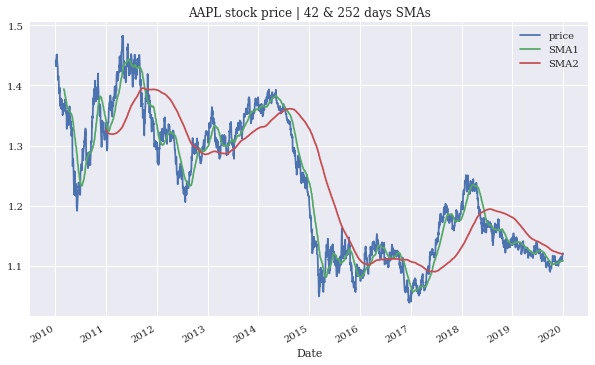

In [89]:
data.plot(title='AAPL stock price | 42 & 252 days SMAs',
          figsize=(10, 6));
# plt.savefig('../../images/ch04/sma_plot_1.png')

In [90]:
data['position'] = np.where(data['SMA1'] > data['SMA2'],
                            1, -1)

In [91]:
data.dropna(inplace=True)

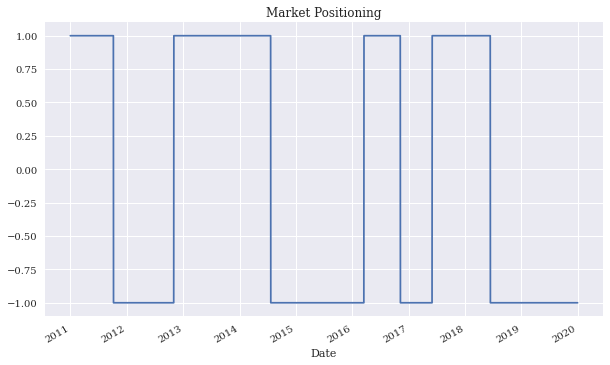

In [92]:
data['position'].plot(ylim=[-1.1, 1.1],
                      title='Market Positioning',
                      figsize=(10, 6));
# plt.savefig('../../images/ch04/sma_plot_2.png')

In [93]:
data['returns'] = np.log(data['price'] / data['price'].shift(1))

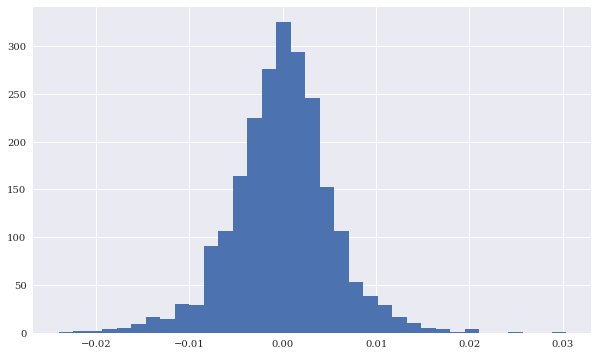

In [94]:
data['returns'].hist(bins=35, figsize=(10, 6));
# plt.savefig('../../images/ch04/sma_plot_3.png')

In [95]:
data['strategy'] = data['position'].shift(1) * data['returns']

In [96]:
data[['returns', 'strategy']].sum()

returns    -0.176731
strategy    0.253121
dtype: float64

In [97]:
data[['returns', 'strategy']].sum().apply(np.exp)

returns     0.838006
strategy    1.288039
dtype: float64

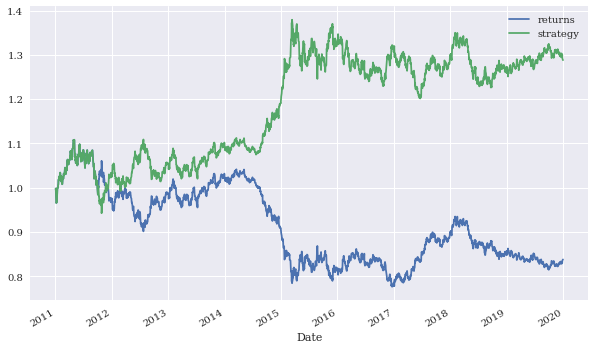

In [98]:
data[['returns', 'strategy']].dropna().cumsum(
            ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch04/sma_plot_4.png')

In [99]:
data[['returns', 'strategy']].mean() * 252

returns    -0.019671
strategy    0.028174
dtype: float64

In [100]:
data[['returns', 'strategy']].std() * 252 ** 0.5

returns     0.085414
strategy    0.085405
dtype: float64

In [101]:
data['cumret'] = data['strategy'].cumsum().apply(np.exp)

In [102]:
data['strategy'].iloc[-1]

-0.001160351806008741

In [103]:
data

,price,SMA1,SMA2,position,returns,strategy,cumret
Date,,,,,,,
2010-12-31,1.3377,1.342579,1.326218,1,NaN,NaN,NaN
2011-01-03,1.3351,1.340945,1.325798,1,-0.001946,-0.001946,0.998056
2011-01-04,1.3301,1.338940,1.325374,1,-0.003752,-0.003752,0.994319
2011-01-05,1.3151,1.336448,1.324874,1,-0.011341,-0.011341,0.983105
2011-01-06,1.3001,1.333995,1.324351,1,-0.011472,-0.011472,0.971892
...,...,...,...,...,...,...,...
2019-12-24,1.1087,1.107698,1.119630,-1,0.000090,-0.000090,1.302328
2019-12-26,1.1096,1.107740,1.119529,-1,0.000811,-0.000811,1.301272
2019-12-27,1.1175,1.107924,1.119428,-1,0.007094,-0.007094,1.292073


In [104]:
data['cummax'] = data['cumret'].cummax()

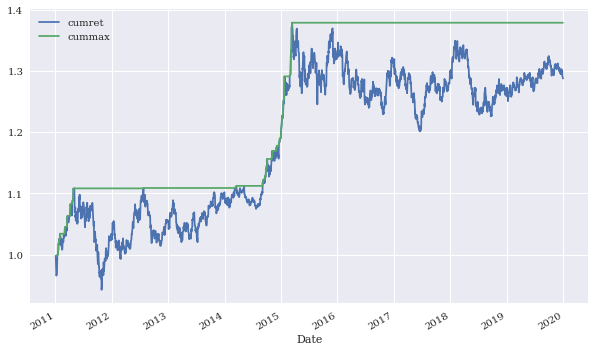

In [105]:
data[['cumret', 'cummax']].dropna().plot(figsize=(10, 6));
# plt.savefig('../../images/ch04/sma_plot_5.png')

In [106]:
drawdown = data['cummax'] - data['cumret']

In [107]:
drawdown.max()

0.17779367070195895

In [108]:
temp = drawdown[drawdown == 0]

In [109]:
periods = (temp.index[1:].to_pydatetime() -
           temp.index[:-1].to_pydatetime())

In [110]:
periods[12:15]

array([datetime.timedelta(days=1), datetime.timedelta(days=1),
       datetime.timedelta(days=10)], dtype=object)

In [111]:
periods.max()

datetime.timedelta(days=596)

### Generalizing the Approach

In [112]:
import SMAVectorBacktester as SMA

In [113]:
smabt = SMA.SMAVectorBacktester('EUR=', 42, 252,
                                '2010-1-1', '2019-12-31') 

In [114]:
smabt.run_strategy()

(1.29, 0.45)

In [115]:
%%time
smabt.optimize_parameters((30, 50, 2),
                          (200, 300, 2))

CPU times: user 1.19 s, sys: 5.04 ms, total: 1.19 s
Wall time: 1.19 s


(array([ 48., 238.]), 1.5)

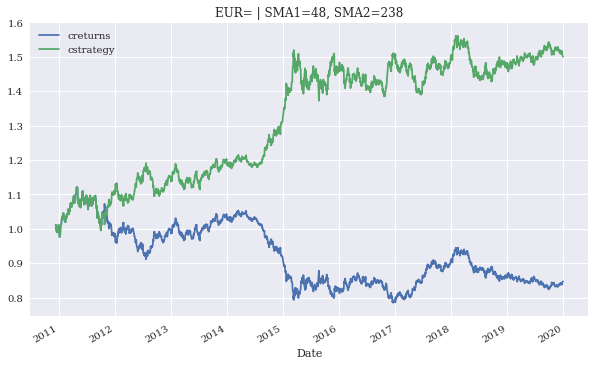

In [116]:
smabt.plot_results()
# plt.savefig('../../images/ch04/sma_plot_6.png')

## Strategies based on Momentum

### Getting into the Basics

In [117]:
data = pd.DataFrame(raw['XAU='])

In [118]:
data.tail()

,XAU=
Date,
2019-12-24,1498.8100
2019-12-26,1511.2979
2019-12-27,1510.4167
2019-12-30,1515.1230
2019-12-31,1517.0100


In [119]:
data.rename(columns={'XAU=': 'price'}, inplace=True)

In [120]:
data['returns'] = np.log(data['price'] / data['price'].shift(1))

In [121]:
data['position'] = np.sign(data['returns'])

In [122]:
data['strategy'] = data['position'].shift(1) * data['returns']

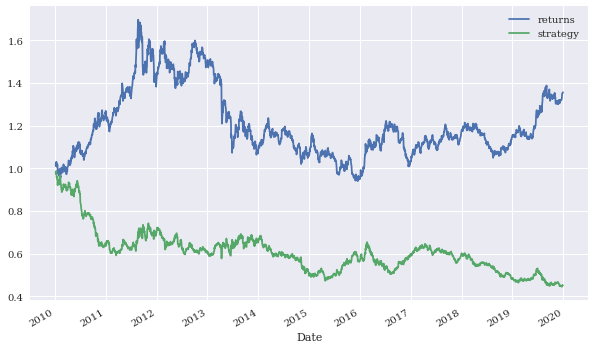

In [123]:
data[['returns', 'strategy']].dropna().cumsum(
            ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch04/mom_plot_1.png')

In [124]:
data['position'] = np.sign(data['returns'].rolling(3).mean())

In [125]:
data['strategy'] = data['position'].shift(1) * data['returns']

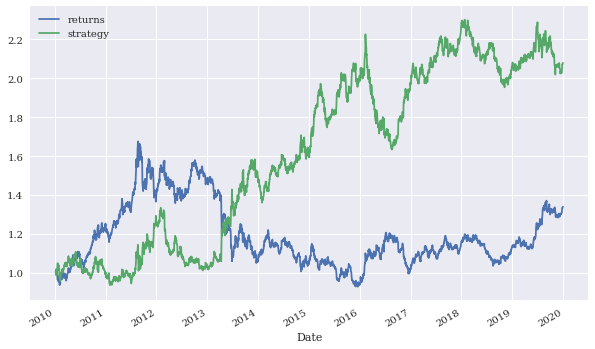

In [126]:
data[['returns', 'strategy']].dropna().cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch04/mom_plot_2.png')

#### Intraday Data from Eikon

In [127]:
fn = '../data/AAPL_1min_05052020.csv'
# fn = '../data/SPX_1min_05052020.csv'

In [128]:
data = pd.read_csv(fn, index_col=0, parse_dates=True)

In [129]:
data.tail()

,HIGH,LOW,OPEN,CLOSE,COUNT,VOLUME
Date,,,,,,
2020-05-05 19:56:00,298.730,298.15,298.73,298.50,2541.0,207257.0
2020-05-05 19:57:00,298.495,297.71,298.49,297.90,2220.0,173279.0
2020-05-05 19:58:00,298.000,297.68,297.90,297.70,2243.0,194269.0
2020-05-05 19:59:00,297.890,297.35,297.70,297.83,2893.0,294453.0
2020-05-05 20:00:00,298.210,297.31,297.83,297.77,3657.0,368730.0


In [130]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 241 entries, 2020-05-05 16:00:00 to 2020-05-05 20:00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HIGH    241 non-null    float64
 1   LOW     241 non-null    float64
 2   OPEN    241 non-null    float64
 3   CLOSE   241 non-null    float64
 4   COUNT   241 non-null    float64
 5   VOLUME  241 non-null    float64
dtypes: float64(6)
memory usage: 13.2 KB


In [131]:
data['returns'] = np.log(data['CLOSE'] /
                         data['CLOSE'].shift(1))

In [132]:
to_plot = ['returns']

In [133]:
for m in [1, 3, 5, 7, 9]:
    data['position_%d' % m] = np.sign(data['returns'].rolling(m).mean())
    data['strategy_%d' % m] = (data['position_%d' % m].shift(1) *
                               data['returns'])
    to_plot.append('strategy_%d' % m) 

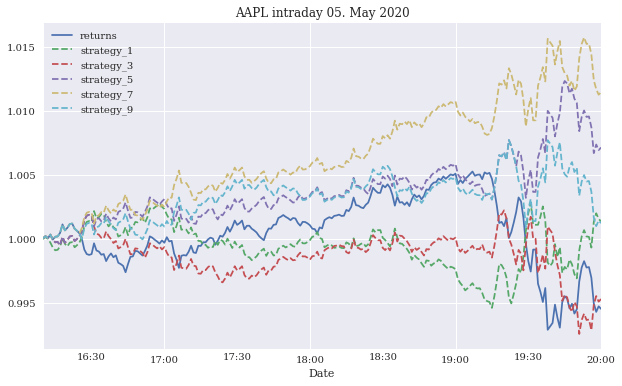

In [134]:
data[to_plot].dropna().cumsum().apply(np.exp).plot(
    title='AAPL intraday 05. May 2020',
    figsize=(10, 6), style=['-', '--', '--', '--', '--', '--']);
# plt.savefig('../../images/ch04/mom_plot_4.png')
# plt.savefig('../../images/ch04/mom_plot_5.png')

### Generalizing the Approach

In [135]:
import MomVectorBacktester as Mom

In [136]:
mombt = Mom.MomVectorBacktester('XAU=', '2010-1-1',
                                '2019-12-31', 10000, 0.0)

In [137]:
mombt.run_strategy(momentum=3)

(20797.87, 7395.53)

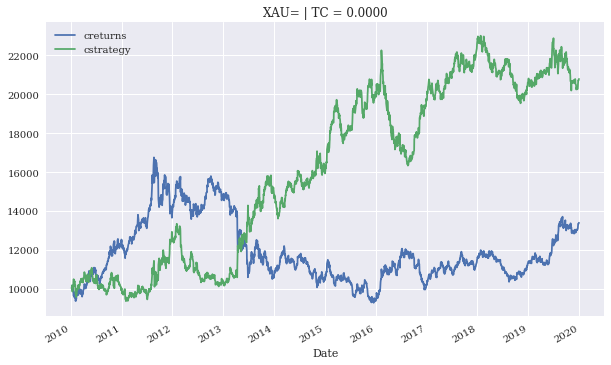

In [138]:
mombt.plot_results()
# plt.savefig('../../images/ch04/mom_plot_6.png')

In [139]:
mombt = Mom.MomVectorBacktester('XAU=', '2010-1-1',
                                '2019-12-31', 10000, 0.001)

In [140]:
mombt.run_strategy(momentum=3)

(10749.4, -2652.93)

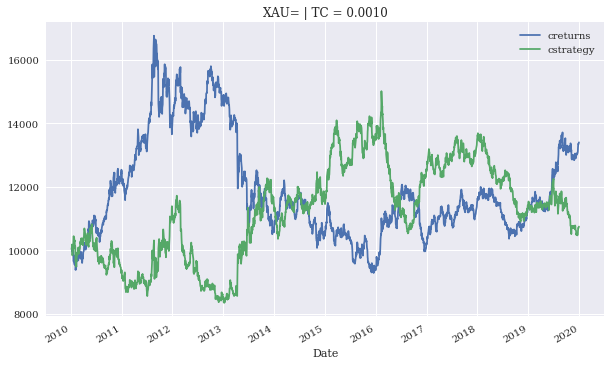

In [141]:
mombt.plot_results()
# plt.savefig('../../images/ch04/mom_plot_7.png')

## Strategies based on Mean-Reversion

### Getting into the Basics

In [95]:
data = pd.DataFrame(raw['GDX'])

In [96]:
data.rename(columns={'GDX': 'price'}, inplace=True)

In [97]:
data['returns'] = np.log(data['price'] /
                         data['price'].shift(1))

In [98]:
SMA = 25

In [99]:
data['SMA'] = data['price'].rolling(SMA).mean()

In [100]:
threshold = 3.5

In [101]:
data['distance'] = data['price'] - data['SMA']

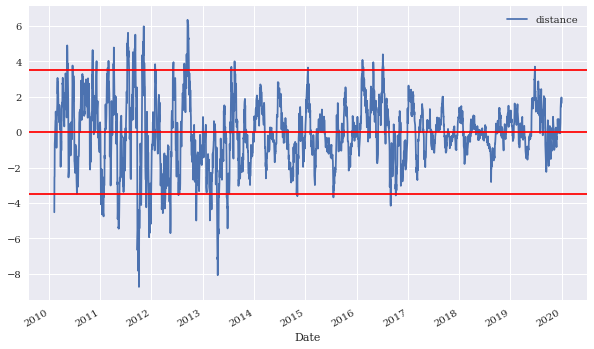

In [102]:
data['distance'].dropna().plot(figsize=(10, 6), legend=True)
plt.axhline(threshold, color='r')
plt.axhline(-threshold, color='r')
plt.axhline(0, color='r');
# plt.savefig('../../images/ch04/mr_plot_1.png')

In [103]:
data['position'] = np.where(data['distance'] > threshold,
                            -1, np.nan)

In [104]:
data['position'] = np.where(data['distance'] < -threshold,
                            1, data['position'])

In [105]:
data['position'] = np.where(data['distance'] *
            data['distance'].shift(1) < 0, 0, data['position'])

In [106]:
data['position'] = data['position'].ffill().fillna(0)

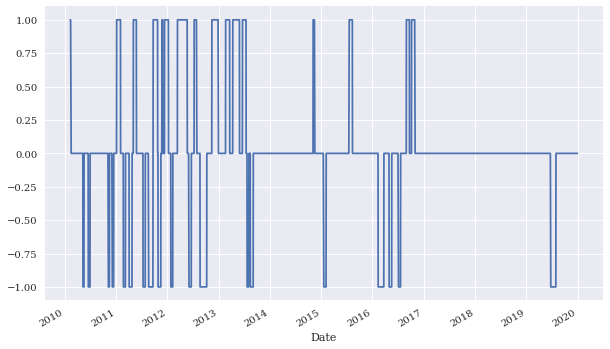

In [107]:
data['position'].iloc[SMA:].plot(ylim=[-1.1, 1.1],
                               figsize=(10, 6));
# plt.savefig('../../images/ch04/mr_plot_2.png')

In [108]:
data['strategy'] = data['position'].shift(1) * data['returns']

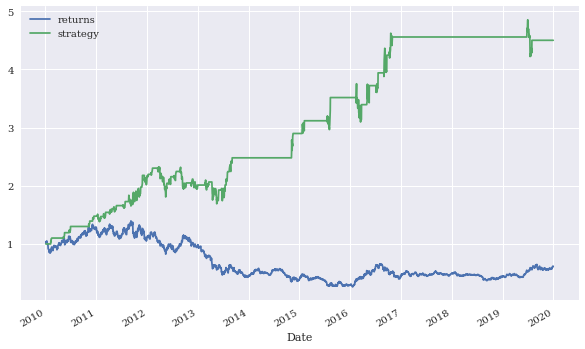

In [109]:
data[['returns', 'strategy']].dropna().cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch04/mr_plot_3.png')

### Generalizing the Approach 

In [110]:
import MRVectorBacktester as MR

In [111]:
mrbt = MR.MRVectorBacktester('GLD', '2010-1-1', '2019-12-31',
                             10000, 0.001)

In [112]:
mrbt.run_strategy(SMA=43, threshold=7.5)

(14599.04, 3891.53)

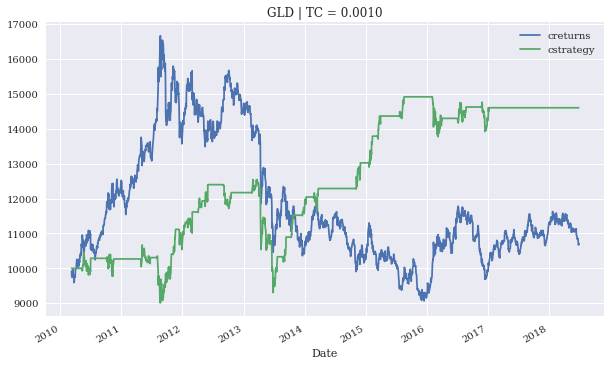

In [113]:
mrbt.plot_results()
# plt.savefig('../../images/ch04/mr_plot_4.png')

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:training@tpq.io">training@tpq.io</a>